# Neural Rubik's cube solver

### Rubik's cube definition as a 3-D tensor

In [44]:
import torch
import numpy as np
def init_cube():
    cube = torch.zeros((5, 5, 5))
    cube[1:4, 1:4, 4] = 1  # Right face
    cube[1:4, 1:4, 0] = 2  # Left face
    cube[0, 1:4, 1:4] = 3  # Up face
    cube[4, 1:4, 1:4] = 4  # Down face
    cube[1:4, 4, 1:4] = 5  # Front face
    cube[1:4, 0, 1:4] = 6  # Back face
    return cube

# represent the solved cube as a 3-D tensor
RUBIKS_CUBE = init_cube()
# scramble the cube up to this many moves
MAX_MOVES = 10
# make this many passes over the dataset
NUM_EPOCHS = 100

### Scrambling

In [45]:
import random

move_types = ["R", "RP", "L", "LP", "U", "UP", "D", "DP", "F", "FP", "B", "BP"]

def move(cube, move_type):
    cube = cube.squeeze()
    cube = cube.clone()
    
    if move_type == "U":
        cube[0:2] = torch.rot90(cube[0:2], 1, (2, 1))
    elif move_type == "UP":
        cube[0:2] = torch.rot90(cube[0:2], -1, (2, 1))
    elif move_type == "D":
        cube[3:5] = torch.rot90(cube[3:5], 1, (2, 1))
    elif move_type == "DP":
        cube[3:5] = torch.rot90(cube[3:5], -1, (2, 1))
    elif move_type == "L":
        cube[:,:, 0:2] = torch.rot90(cube[:, :, 0:2], 1, (1, 0))
    elif move_type == "LP":
        cube[:,:, 0:2] = torch.rot90(cube[:, :, 0:2], -1, (1, 0))
    elif move_type == "R":
        cube[:,:, 3:5] = torch.rot90(cube[:,:, 3:5], -1, (1, 0))
    elif move_type == "RP":
        cube[:,:, 3:5] = torch.rot90(cube[:,:, 3:5], 1, (1, 0))
    elif move_type == "F":
        cube[:, 3:5] = torch.rot90(cube[:, 3:5], 1, (2, 0))
    elif move_type == "FP":
        cube[:, 3:5] = torch.rot90(cube[:, 3:5], -1, (2, 0))
    elif move_type == "B":
        cube[:, 0:2] = torch.rot90(cube[:, 0:2], -1, (2, 0))
    elif move_type == "BP":
        cube[:, 0:2] = torch.rot90(cube[:, 0:2], 1, (2, 0))
    return cube
        
def apply_moves(cube, moves):
    for m in moves:
        cube = move(cube, m)
    return cube

def reverse_moves(moves):
    # Turn clockwise moves into counter-clockwise and vice versa
    # Also reverse the order of moves
    result = []
    for m in moves:
      result.append(reverse_move(m))
    return list(reversed(result))

def reverse_move(m):
    # Turn clockwise moves into counter-clockwise and vice versa
    if m.endswith("P"):
      return  m[0]
    return m + "P"


## Data Loader


In [46]:
from torch.utils.data import Dataset, DataLoader

def generate_data(num_samples):
    data = []
    seen_states = set()
    while len(data) < num_samples:
        moves = random.choices(move_types, k=random.randint(1, MAX_MOVES))
        scrambled_cube = apply_moves(RUBIKS_CUBE.clone(), moves)
        best_move = reverse_move(moves[-1])
        
        cube_list = scrambled_cube.flatten().cpu().tolist()
        cube_tuple = tuple(cube_list)
        # Do not add if we have seen this scramble before
        if cube_tuple not in seen_states:
                seen_states.add(cube_tuple)
                # add the reverse of the last move as the best move
                data.append((scrambled_cube, best_move))

    return data

class RubiksCubeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


## Neural Network

In [47]:
import torch.nn as nn
import torch.nn.functional as F
class RubiksSolverNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Create separate datasets for training and evaluation
        combined_data = generate_data(101000)
        random.shuffle(combined_data)
        
        train_data = combined_data[:100000]
        eval_data  = combined_data[100000:]
        self.train_dataset = RubiksCubeDataset(train_data)
        self.eval_dataset = RubiksCubeDataset(eval_data)

        # Create data loaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=32)
        self.eval_loader = DataLoader(self.eval_dataset, batch_size=1)

        # Define a convolutional layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # 16 output channels
        
        # Define a Linear layer for the flattened convolution output
        self.fc1 = nn.Linear(16 * 5 * 5 * 5, 128)  # 16 channels * 5x5x5 cube size
        self.fc2 = nn.Linear(128, 12)  # 12 output moves

    def train(self):
        losses = []
        for cubes, best_moves in self.train_loader:
            # cubes is of shape 32x5x5x5
            # Convert moves to indices. R -> 0, RP -> 1, L -> 2 and so on.
            best_moves = torch.tensor([move_types.index(m) for m in best_moves])
            # Forward pass
            output = self.forward(cubes)
            # output is of shape 32x12

            # cross-entropy loss
            log_probs = torch.log_softmax(output, dim=1)  # Log probabilities
            # at this point, log_probs is a matrix of shape 32x12
            best_log_probs = log_probs[range(len(best_moves)), best_moves]
            # best_log_probs is a column vector with 32 rows
            loss = -best_log_probs.mean()  # Negative log-likelihood

            # Compute gradients using autograd
            loss.backward()

            
            # Gradient descent updates
            with torch.no_grad():
                for param in self.parameters():
                    param -= 0.001 * param.grad
                    param.grad.zero_()

            losses.append(loss.item())
        print(f"Training Loss: {np.mean(losses):.4f}")

    def solve(self, cube):
        solved = False
        for _ in range(2 * MAX_MOVES):  # Try up to these many moves
            output = self.forward(cube)
            predicted_move_index = torch.argmax(output, dim=1).item()
            predicted_move = move_types[predicted_move_index]

            # Apply the predicted move to the cube
            cube = move(cube, predicted_move)
            # Check if the cube is solved
            if np.array_equal(cube, RUBIKS_CUBE):
                solved = True
                break

            # add batch dimension to make the shape (1, 5, 5, 5)
            # this is because forward() expects a batch dimension.
            cube.unsqueeze_(0)
        return cube.squeeze(), solved

    def eval(self):
        correct = 0
        total = 0

        for cube, _ in self.eval_loader:  # batch_size=1 ensures cube has shape (1, 5, 5, 5)
            cube, solved = self.solve(cube)
            if solved:
                correct += 1
            total += 1
        accuracy = 100 * correct / total
        print(f"Percentage of correctly solved cubes: {accuracy:.2f}%")
        return accuracy
    
    def forward(self, x):
        # Input shape: (batch_size, 5, 5, 5)
        # Add channel dimension => (batch_size, 1, depth=5, height=5, width=5)
        x = x.unsqueeze(1)
        
        # Pass through convolutional layer
        x = F.relu(self.conv1(x))  # Output shape: (batch_size, 16, 5, 5)
        
        # Flatten the output
        x = x.reshape(x.size(0), -1)  # Output shape: (batch_size, 16 * 5 * 5)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output shape: (batch_size, 128)
        return self.fc2(x)  # Output shape: (batch_size, 12)

    

# Instantiate the neural network
net = RubiksSolverNetwork()


# Training & Eval

Epoch 0
Training Loss: 2.4396
Percentage of correctly solved cubes: 0.60%
Epoch 1
Training Loss: 2.3646
Percentage of correctly solved cubes: 1.20%
Epoch 2
Training Loss: 2.3280
Percentage of correctly solved cubes: 2.30%
Epoch 3
Training Loss: 2.3093
Percentage of correctly solved cubes: 3.00%
Epoch 4
Training Loss: 2.2942
Percentage of correctly solved cubes: 4.30%
Epoch 5
Training Loss: 2.2788
Percentage of correctly solved cubes: 5.50%
Epoch 6
Training Loss: 2.2625
Percentage of correctly solved cubes: 6.20%
Epoch 7
Training Loss: 2.2444
Percentage of correctly solved cubes: 7.20%
Epoch 8
Training Loss: 2.2240
Percentage of correctly solved cubes: 7.70%
Epoch 9
Training Loss: 2.2010
Percentage of correctly solved cubes: 8.80%
Epoch 10
Training Loss: 2.1758
Percentage of correctly solved cubes: 9.90%
Epoch 11
Training Loss: 2.1486
Percentage of correctly solved cubes: 11.90%
Epoch 12
Training Loss: 2.1199
Percentage of correctly solved cubes: 13.90%
Epoch 13
Training Loss: 2.0902
Pe

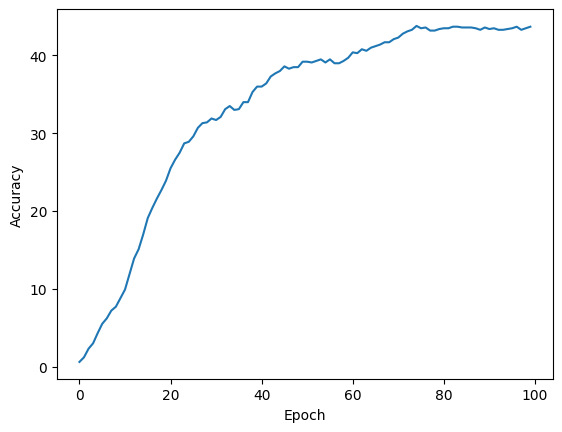

In [48]:
import matplotlib.pyplot as plt

eval_accuracies = []
for epoch in range(NUM_EPOCHS):
  print("Epoch", epoch)
  net.train()
  acc = net.eval()
  eval_accuracies.append(acc)

# plot accuracies
plt.plot(eval_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()



In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def display_cube(cube):
    faces = [cube[0], cube[4], cube[:, 0], cube[:, 4], cube[:, :, 0], cube[:, :, 4]]
    colors = ["black", "red", "orange", "white", "yellow", "green", "blue"]
    cmap = mcolors.ListedColormap(colors)
    titles = ["Up", "Down", "Back", "Front", "Left", "Right"]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    for ax, face, title in zip(axes.flat, faces, titles):
        ax.imshow(face, cmap=cmap, vmin=0, vmax=6)
        ax.set_title(title)
        ax.axis("off")

    plt.show()

# Demo

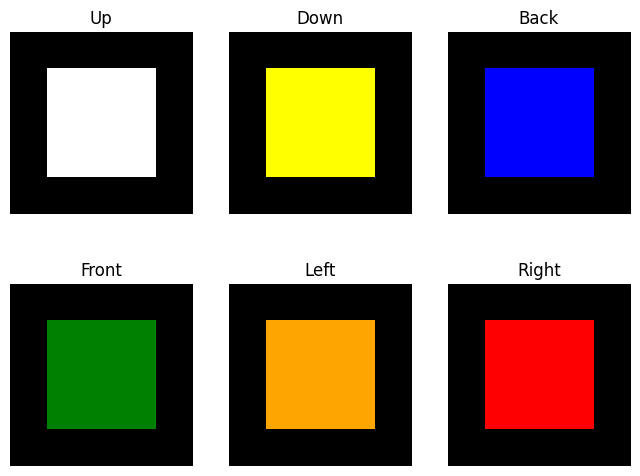

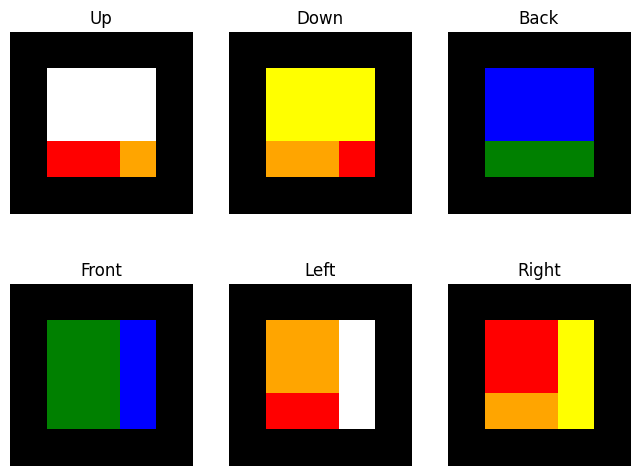

solved True


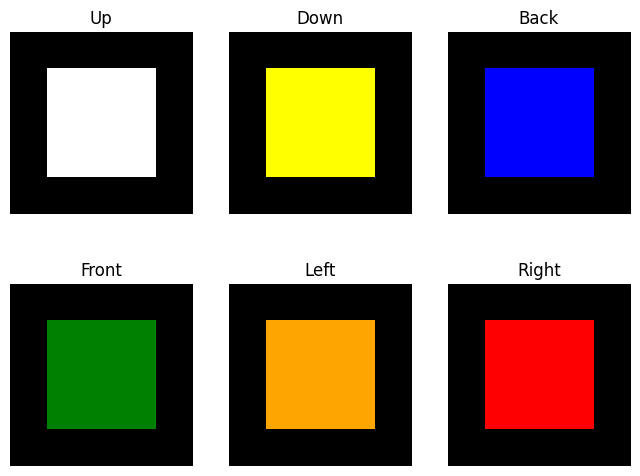

In [50]:
# Initialize and display the cube
cube = init_cube()
display_cube(cube)

num_moves = np.random.randint(1, MAX_MOVES)
moves = random.choices(move_types, k=num_moves)
scrambled_cube = apply_moves(cube, moves)
display_cube(scrambled_cube)
cube, solved = net.solve(scrambled_cube.unsqueeze(0))
print("solved", solved)
display_cube(cube)

# Calculate evaluation accuracy another way

In [51]:
total = 1000
correct = 0
for i in range(total):
    cube = init_cube()
    num_moves = np.random.randint(1, MAX_MOVES)
    moves = random.choices(move_types, k=num_moves)
    scrambled_cube = apply_moves(cube, moves)
    cube, solved = net.solve(scrambled_cube.unsqueeze(0))
    correct += solved

acc = correct * 100 / total
print(f"accuracy {acc:.2f}%")

accuracy 76.50%
